In [1]:
import random
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score
sns.set_style(style="ticks")
import warnings
warnings.filterwarnings('ignore')

In [2]:
#########################################################################################################

######################## Citirea datelor si eliminarea intrarilor nule ##################################

#########################################################################################################


df = pd.read_csv('Training Data.csv') #Citirea setului de date
print("Numarul de valori nule pentru fiecare atribut:")
print(df.isnull().sum()) #Aflarea valorilor nule din dataset

df.head()


Numarul de valori nule pentru fiecare atribut:
Id                   0
Income               0
Age                  0
Experience           0
Married/Single       0
House_Ownership      0
Car_Ownership        0
Profession           0
CITY                 0
STATE                0
CURRENT_JOB_YRS      0
CURRENT_HOUSE_YRS    0
Risk_Flag            0
dtype: int64


,Id,Income,Age,Experience,Married/Single,House_Ownership,Car_Ownership,Profession,CITY,STATE,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
0,1,1303834,23,3,single,rented,no,Mechanical_engineer,Rewa,Madhya_Pradesh,3,13,0
1,2,7574516,40,10,single,rented,no,Software_Developer,Parbhani,Maharashtra,9,13,0
2,3,3991815,66,4,married,rented,no,Technical_writer,Alappuzha,Kerala,4,10,0
3,4,6256451,41,2,single,rented,yes,Software_Developer,Bhubaneswar,Odisha,2,12,1
4,5,5768871,47,11,single,rented,no,Civil_servant,Tiruchirappalli[10],Tamil_Nadu,3,14,1


In [3]:
print(df.dtypes)

Id                    int64
Income                int64
Age                   int64
Experience            int64
Married/Single       object
House_Ownership      object
Car_Ownership        object
Profession           object
CITY                 object
STATE                object
CURRENT_JOB_YRS       int64
CURRENT_HOUSE_YRS     int64
Risk_Flag             int64
dtype: object


In [4]:
#########################################################################################################

#########################################  Studierea datelor ############################################

#########################################################################################################

#Schimbarea coloanelor de tip 'object' in tip 'category':
df_obj = df.select_dtypes(include=['object']).copy()

for col in df_obj.columns:
    df[col] = df[col].astype('category')

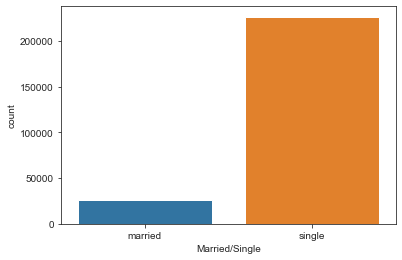

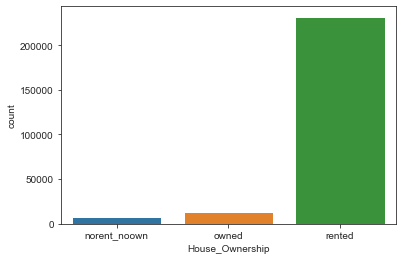

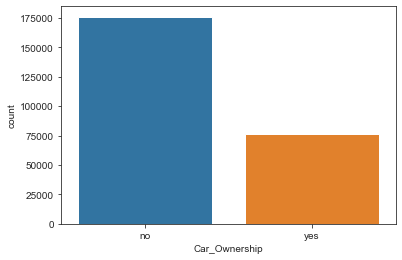

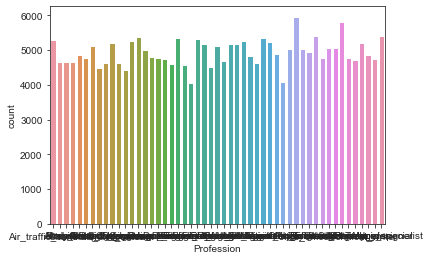

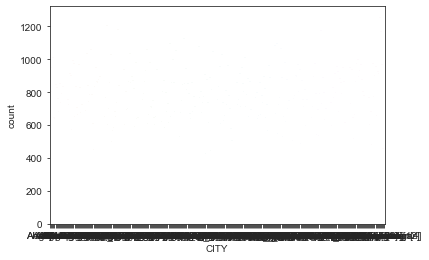

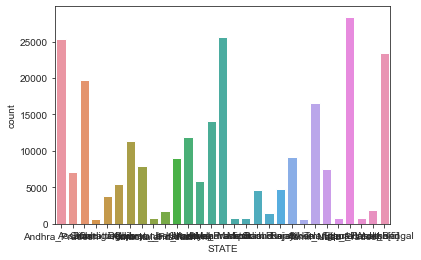

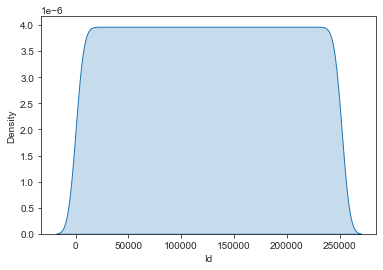

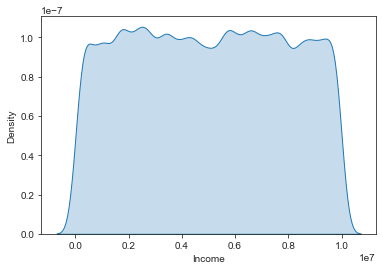

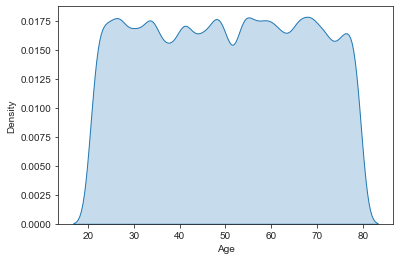

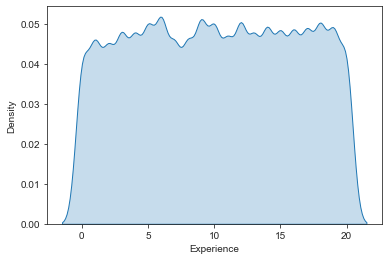

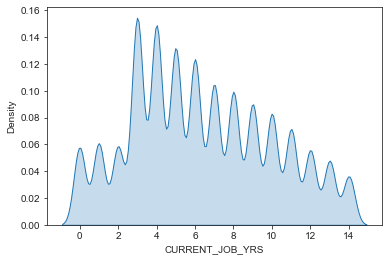

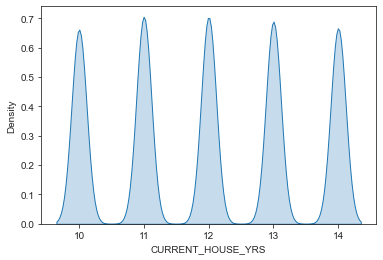

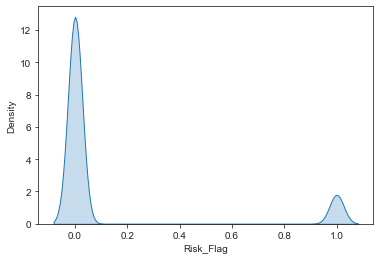

Numarul de orase raportate: 
317


In [5]:
for column in df_obj.columns:
    plt.figure()
    sns.countplot(df[column])
    plt.show()
    
for column in df.columns:
    if(column not in df_obj.columns):
        plt.figure()
        sns.kdeplot(df[column],shade = True)
        plt.show()

all_cities = df.CITY.unique()
print("Numarul de orase raportate: ")
print(len(all_cities))
        
#Coloana 'CITY' are mult prea multe categorii si nu prezinta nicio insemnatate statistica, asa ca o vom elimina:
df.drop('CITY', inplace = True, axis = 1)
df_obj.drop('CITY', inplace = True, axis = 1)

#Nu avem nevoie nici de coloana 'ID' asa ca o vom elimina si pe ea
df.drop('Id', inplace = True, axis = 1)


<Figure size 432x288 with 0 Axes>

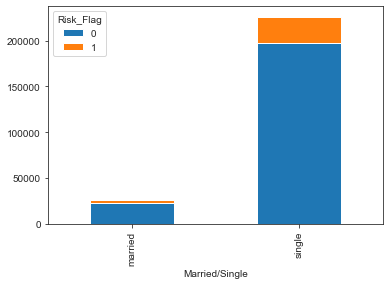

<Figure size 432x288 with 0 Axes>

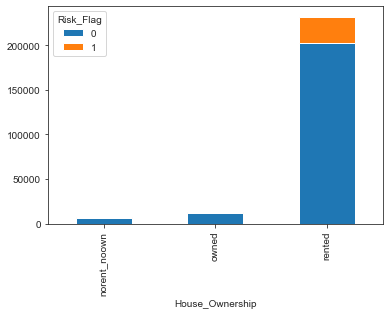

<Figure size 432x288 with 0 Axes>

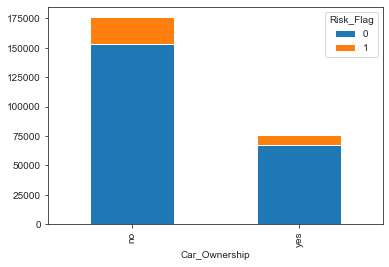

<Figure size 432x288 with 0 Axes>

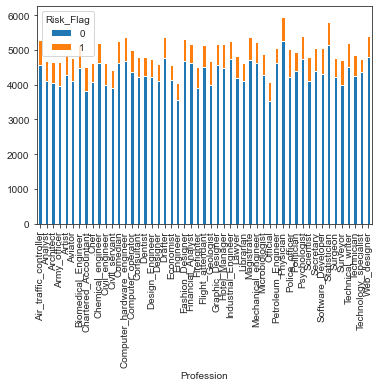

<Figure size 432x288 with 0 Axes>

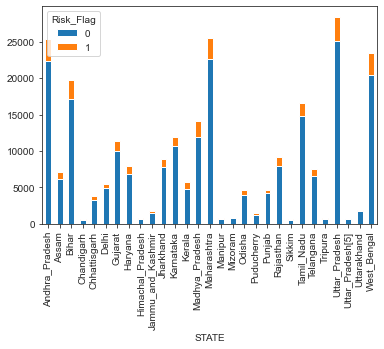

<Figure size 432x288 with 0 Axes>

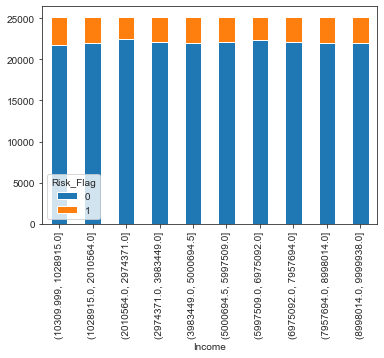

<Figure size 432x288 with 0 Axes>

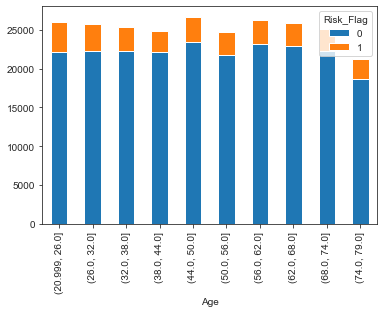

<Figure size 432x288 with 0 Axes>

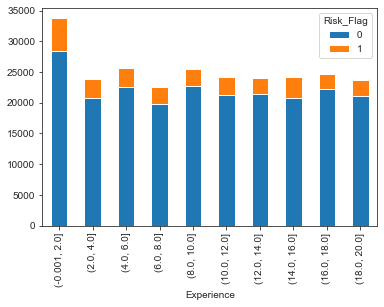

<Figure size 432x288 with 0 Axes>

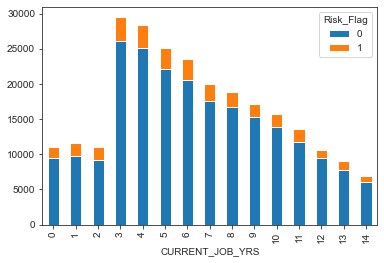

<Figure size 432x288 with 0 Axes>

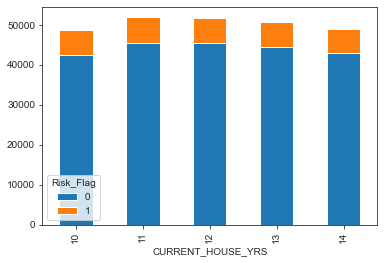

In [6]:
#Distributiile fiecarei variabile in raport cu variabila tinta:
for column in df_obj.columns:
    plt.figure()
    pd.crosstab(df[column], df['Risk_Flag']).plot.bar(stacked = True)
    plt.show()
    
income = pd.qcut(df['Income'], q = 10)
age = pd.qcut(df['Age'], q = 10)
experience = pd.qcut(df['Experience'], q = 10)
curr_job_yrs = df['CURRENT_JOB_YRS']
curr_house_yrs = df['CURRENT_HOUSE_YRS']

numerical_columns = (income, age, experience, curr_job_yrs, curr_house_yrs)
for col in numerical_columns:
    plt.figure()
    pd.crosstab(col, df['Risk_Flag']).plot.bar(stacked = True)
    plt.show()

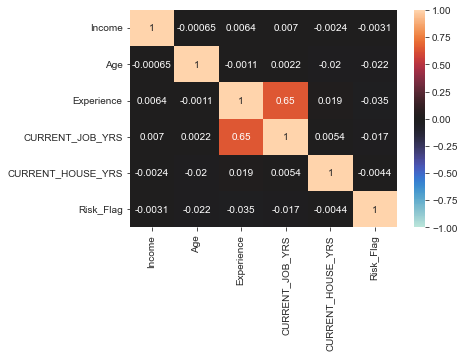

In [7]:
#Matricea de corelatie:
plt.figure()
sns.heatmap(df.select_dtypes(['int64']).corr(), vmin = -1, vmax = 1, center = 0, annot = True)
plt.show()

In [8]:
cat_df = df.select_dtypes(include=['category']).copy()
for column in cat_df.columns:
    print(column,': Most frequent: ', df[column].value_counts().idxmax(), "; Least Frequent: ", df[column].value_counts().idxmin())
#se observa din aceste date si din ploturile de distributie faptul ca atributele ramase au insemnatate statistica, dat fiind faptul ca nu exista valori izolate sau cu frecventa extrem de scazuta.


Married/Single : Most frequent:  single ; Least Frequent:  married
House_Ownership : Most frequent:  rented ; Least Frequent:  norent_noown
Car_Ownership : Most frequent:  no ; Least Frequent:  yes
Profession : Most frequent:  Physician ; Least Frequent:  Engineer
STATE : Most frequent:  Uttar_Pradesh ; Least Frequent:  Sikkim


In [9]:
#Valorile medii, minime, maxime si cuantilele 25%, 50%, 75%:
df.describe()

,Income,Age,Experience,CURRENT_JOB_YRS,CURRENT_HOUSE_YRS,Risk_Flag
count,2.520000e+05,252000.000000,252000.000000,252000.000000,252000.000000,252000.000000
mean,4.997117e+06,49.954071,10.084437,6.333877,11.997794,0.123000
std,2.878311e+06,17.063855,6.002590,3.647053,1.399037,0.328438
min,1.031000e+04,21.000000,0.000000,0.000000,10.000000,0.000000
25%,2.503015e+06,35.000000,5.000000,3.000000,11.000000,0.000000
50%,5.000694e+06,50.000000,10.000000,6.000000,12.000000,0.000000
75%,7.477502e+06,65.000000,15.000000,9.000000,13.000000,0.000000
max,9.999938e+06,79.000000,20.000000,14.000000,14.000000,1.000000


In [10]:
#########################################################################################################

##################################### Detectarea anomaliilor ############################################

#########################################################################################################

import numpy as np
from pyod.models.pca import PCA

y = df['Risk_Flag']
X = df.drop('Risk_Flag', inplace = False, axis = 'columns')
X = df.select_dtypes('int64')

clf = PCA(contamination = 0.02)
clf.fit(X)

print('Procentajul de anomalii: ',np.sum(clf.labels_)/X.shape[0])

Procentajul de anomalii:  0.02


In [11]:
#########################################################################################################

######################## Schimbarea datelor categorice in date numerice #################################

#########################################################################################################

#Prelucrarea datelor ordinale:
house_own_dict = {'norent_noown' : 0, 'rented' : 1, 'owned': 2}
car_own_dict = {'no': 0, 'yes': 1}

df['House_Ownership'] = df['House_Ownership'].map(house_own_dict)
df['Car_Ownership'] = df['Car_Ownership'].map(car_own_dict)

#Prelucrarea datelor categorice:
label_encoder = LabelEncoder()
cat_columns = df.select_dtypes(['category']).columns
for column in cat_columns:
    df[column] = label_encoder.fit_transform(df[column])

In [12]:
#########################################################################################################

############################ Tratarea dezechilibrului din setul de date #################################

#########################################################################################################


from collections import Counter
from imblearn.over_sampling import RandomOverSampler
sampler = RandomOverSampler(sampling_strategy=0.25)
X = df.drop('Risk_Flag', inplace = False, axis = 1);
y = df.Risk_Flag
print("Inainte de tratarea esantioanelor prin oversampling: Risk_flag:" + str(Counter(y)))
X, y = sampler.fit_resample(X, y)
print("Dupa tratarea esantioanelor prin oversampling: Risk_flag:" + str(Counter(y)))

from imblearn.under_sampling import RandomUnderSampler
sampler = RandomUnderSampler(sampling_strategy=1.0)

print("Inainte de tratarea esantioanelor prin undersampling: Risk_flag:" + str(Counter(y)))
X, y = sampler.fit_resample(X, y)
print("Dupa de tratarea esantioanelor prin undersampling: Risk_flag:" + str(Counter(y)))

df = X.assign(Risk_Flag=y)

Inainte de tratarea esantioanelor prin oversampling: Risk_flag:Counter({0: 221004, 1: 30996})
Dupa tratarea esantioanelor prin oversampling: Risk_flag:Counter({0: 221004, 1: 55251})
Inainte de tratarea esantioanelor prin undersampling: Risk_flag:Counter({0: 221004, 1: 55251})
Dupa de tratarea esantioanelor prin undersampling: Risk_flag:Counter({0: 55251, 1: 55251})


In [13]:
#########################################################################################################

#################################### Construirea modelelor ##############################################

#########################################################################################################

def train_model(model, grid, df):
    kfold = KFold(n_splits = 5, shuffle = True, random_state=random_seed)
    grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, scoring='accuracy',error_score=0)
    y = df['Risk_Flag']
    X = df.drop('Risk_Flag', inplace = False, axis = 'columns')
    results = []
    for train_index, test_index in kfold.split(X):
        X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
        grid_result = grid_search.fit(X_train, y_train)
        print("Best performance: %f, Parameters: %s" % (grid_result.best_score_, grid_result.best_params_))
        results.append(grid_result.best_score_)
    return results

In [14]:
#####ALTA METODA DE OPTIMIZARE A HIPERPARAMETRILOR##########
#import optuna
#def objective(trial): #max_features min_samples_leaf criterion
#    max_features = trial.suggest_float('max_features', 0.1, 0.9)
#    min_samples_leaf = trial.suggest_int('min_samples_leaf', 20, 100)
#    dt_model = tree.DecisionTreeClassifier(min_samples_leaf = min_samples_leaf, max_features = max_features)
#    return sklearn.model_selection.cross_val_score(dt_model, df.drop('Risk_Flag', inplace = False, axis = 1), df.Risk_Flag, n_jobs=-1, cv=3).mean()

In [15]:
#####ALTA METODA DE OPTIMIZARE A HIPERPARAMETRILOR##########
#study = optuna.create_study(direction='maximize')
#study.optimize(objective, n_trials=100)


In [19]:
random_seed = 1
random.seed(random_seed)

#Logistic Regression:

lr_model = LogisticRegression()
penalties = ['l1','l2', 'elasticnet', 'none']
C_values = [0.1, 1, 10];
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
lr_grid = dict(solver=solvers,
               C=C_values,
               penalty = penalties)
lr_results = train_model(lr_model, lr_grid, df)


Best performance: 0.530650, Parameters: {'C': 10, 'penalty': 'l1', 'solver': 'liblinear'}
Best performance: 0.531487, Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}
Best performance: 0.530870, Parameters: {'C': 0.1, 'penalty': 'none', 'solver': 'newton-cg'}
Best performance: 0.531119, Parameters: {'C': 0.1, 'penalty': 'none', 'solver': 'newton-cg'}
Best performance: 0.530542, Parameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}


In [23]:
#Decision Tree Classifier:

dt_model = tree.DecisionTreeClassifier()
max_fts = ["auto", "sqrt", "log2"]
min_samples_leaf = [1, 2, 4, 8]
criteria = ["gini", "entropy", "log_loss"]
dt_params = dict(max_features = max_fts,
    min_samples_leaf = min_samples_leaf,
    criterion = criteria)

dt_results = train_model(dt_model, dt_params, df)

Best performance: 0.898598, Parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 1}
Best performance: 0.899096, Parameters: {'criterion': 'gini', 'max_features': 'auto', 'min_samples_leaf': 1}
Best performance: 0.898576, Parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 1}
Best performance: 0.898599, Parameters: {'criterion': 'entropy', 'max_features': 'sqrt', 'min_samples_leaf': 1}
Best performance: 0.899798, Parameters: {'criterion': 'entropy', 'max_features': 'auto', 'min_samples_leaf': 1}


In [26]:
#Random Forest Classifier:
rf_model = RandomForestClassifier()
#print(model.get_params())

criteria = ["gini", "entropy", "log_loss"]
max_features = ["auto", "sqrt", "log2"]
rf_params = dict(max_features = max_features,
                 criterion = criteria)

rf_results = train_model(rf_model, rf_params, df)

Best performance: 0.900317, Parameters: {'criterion': 'entropy', 'max_features': 'sqrt'}
Best performance: 0.900951, Parameters: {'criterion': 'entropy', 'max_features': 'auto'}
Best performance: 0.900884, Parameters: {'criterion': 'gini', 'max_features': 'auto'}
Best performance: 0.901065, Parameters: {'criterion': 'entropy', 'max_features': 'auto'}
Best performance: 0.902026, Parameters: {'criterion': 'entropy', 'max_features': 'sqrt'}


In [27]:
#Extra Trees Classifier:

xt_model = ExtraTreesClassifier()
#print(xt_model.get_params())

criteria = ["gini", "entropy"]
max_features = ["auto", "sqrt", "log2"]
xt_params = dict(criterion = criteria,
                 max_features = max_features)

xt_results = train_model(xt_model, xt_params, df)

Best performance: 0.898383, Parameters: {'criterion': 'entropy', 'max_features': 'auto'}
Best performance: 0.899209, Parameters: {'criterion': 'gini', 'max_features': 'auto'}
Best performance: 0.899357, Parameters: {'criterion': 'entropy', 'max_features': 'log2'}
Best performance: 0.899323, Parameters: {'criterion': 'entropy', 'max_features': 'auto'}
Best performance: 0.900069, Parameters: {'criterion': 'gini', 'max_features': 'sqrt'}


In [28]:
#AdaBoost Classifier:

ab_model = AdaBoostClassifier(base_estimator = None)
#print(ab_model.get_params())

algorithm = ['SAMME', 'SAMME.R']
learning_rate = [0.5, 0.75, 1, 1.5, 2]

ab_params = dict(learning_rate = learning_rate,
                algorithm = algorithm)

ab_results = train_model(ab_model, ab_params, df)

Best performance: 0.558761, Parameters: {'algorithm': 'SAMME.R', 'learning_rate': 1}
Best performance: 0.555752, Parameters: {'algorithm': 'SAMME.R', 'learning_rate': 1.5}
Best performance: 0.557385, Parameters: {'algorithm': 'SAMME.R', 'learning_rate': 1.5}
Best performance: 0.557634, Parameters: {'algorithm': 'SAMME.R', 'learning_rate': 1}
Best performance: 0.557917, Parameters: {'algorithm': 'SAMME.R', 'learning_rate': 1}


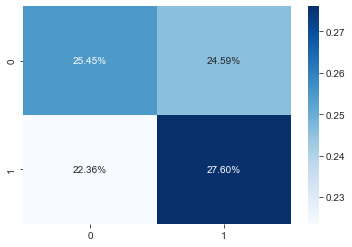

Acuratete pentru Regresie Logistica: 0.5305871280677622


In [24]:
from sklearn.metrics import accuracy_score
y = df['Risk_Flag']
X = df.drop('Risk_Flag', inplace = False, axis = 'columns')
lr = LogisticRegression(C = 1, penalty = "l2", solver = "newton-cg")
X_train, X_test, y_train, y_test = train_test_split(X, y)
lr.fit(X_train,y_train)

y_pred = lr.predict(X_test)

lr_cf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(lr_cf_matrix/np.sum(lr_cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')
plt.show()

print("Acuratete pentru Regresie Logistica:", accuracy_score(y_test, y_pred))

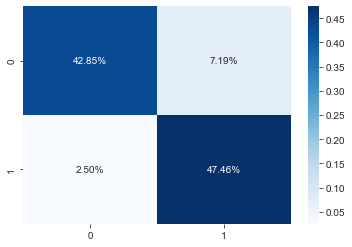

Acuratete pentru Arbore de Decizie: 0.9031709259393325


In [25]:
dt = tree.DecisionTreeClassifier(min_samples_leaf = 1, criterion = "entropy", max_features = "sqrt")
dt.fit(X_train,y_train)

y_pred = dt.predict(X_test)

dt_cf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(dt_cf_matrix/np.sum(dt_cf_matrix), annot = True,
            fmt='.2%', cmap='Blues')
plt.show()

print("Acuratete pentru Arbore de Decizie:",accuracy_score(y_test, y_pred))

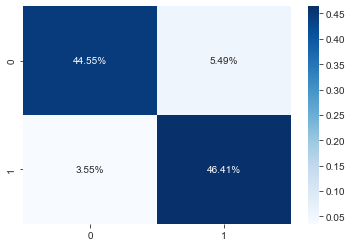

Acuratete pentru Paduri Aleatoare: 0.909541736045754


In [29]:
rf = RandomForestClassifier(criterion = "entropy", max_features = "auto")
rf.fit(X_train,y_train)

y_pred = rf.predict(X_test)

rf_cf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(rf_cf_matrix/np.sum(rf_cf_matrix), annot = True,
            fmt='.2%', cmap='Blues')
plt.show()

print("Acuratete pentru Paduri Aleatoare:", accuracy_score(y_test, y_pred))

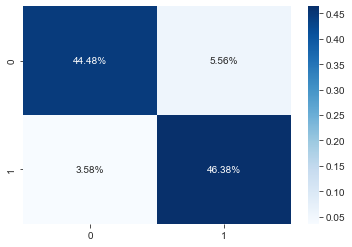

Acuratete pentru Extra Trees: 0.9086729892130602


In [30]:
et = ExtraTreesClassifier(criterion = "entropy", max_features = "auto")
et.fit(X_train,y_train)

y_pred = et.predict(X_test)

et_cf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(et_cf_matrix/np.sum(et_cf_matrix), annot = True,
            fmt='.2%', cmap='Blues')
plt.show()

print("Acuratete pentru Extra Trees:", accuracy_score(y_test, y_pred))

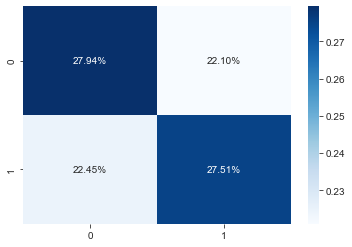

Acuratete pentru Adaboost: 0.5544414681821472


In [31]:
ab = AdaBoostClassifier(algorithm = "SAMME.R", learning_rate = 1)
ab.fit(X_train,y_train)

y_pred = ab.predict(X_test)

ab_cf_matrix = confusion_matrix(y_test, y_pred)

plt.figure()
sns.heatmap(ab_cf_matrix/np.sum(ab_cf_matrix), annot = True,
            fmt='.2%', cmap='Blues')
plt.show()

print("Acuratete pentru Adaboost:", accuracy_score(y_test, y_pred))